In [1]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
import tensorflow as tf


2024-12-31 03:13:50.621286: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-31 03:13:50.621361: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-31 03:13:50.623062: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-31 03:13:50.633851: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import sys
import os

# Add the scripts folder to the system path
scripts_path = os.path.abspath(os.path.join('..', 'scripts/python'))
sys.path.append(scripts_path)


In [21]:
# data_processing.ipynb

# Import necessary libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import tensorflow as tf

from utils import (
    AR,
    check_percentage_tashkeel,
    Clean_data,
    separate_token_with_diacritics,
    factor_shadda_tanwin,
    extract_rhyme_info,
    get_verse_length_features,
    string_with_tashkeel_vectorizer,
    string_with_tashkeel_vectorizer_per_batch,
    calculate_meter_accuracy
)

from transformers import GPT2Tokenizer, TFGPT2LMHeadModel
from sklearn.model_selection import train_test_split

# Configure visualization settings
%matplotlib inline
sns.set(style="whitegrid")


In [12]:
# Define file paths
original_csv = '../data/raw/apcd/apcd_full.csv'
diacritized_csv = '../data/raw/apcd/apcd_full_diacritized.csv'
processed_output_dir = '../data/processed_al_tawil'
os.makedirs(processed_output_dir, exist_ok=True)

In [25]:
# Define meter weight pattern for الطويل
meter_weights = {
    'الطويل': 'فعولن مفاعيلن فعولن مفاعلن فعولن مفاعيلن فعولن مفاعلن'
}


In [14]:
# Load the datasets
print("Loading datasets...")
original_df = pd.read_csv(original_csv, encoding='utf-8-sig')
diacritized_df = pd.read_csv(diacritized_csv, encoding='utf-8-sig')
print(f"Original dataset loaded with {len(original_df)} records.")
print(f"Auto-diacritized dataset loaded with {len(diacritized_df)} records.")

# Ensure both datasets have the same number of records
if len(original_df) != len(diacritized_df):
    raise ValueError("Original and diacritized datasets have different number of records.")

# Compare Albayt columns and merge datasets
print("Comparing Albayt columns and merging datasets...")


Loading datasets...
Original dataset loaded with 1831770 records.
Auto-diacritized dataset loaded with 1831770 records.
Comparing Albayt columns and merging datasets...


In [17]:
def merge_albayt(original, diacritized):
    """
    Compare original and diacritized Albayt columns.
    Retain original if there's a conflict; otherwise, use diacritized.
    """
    if original != diacritized:
        return original
    else:
        return diacritized

original_df['final_albayt'] = original_df.apply(
    lambda row: merge_albayt(row['البيت'], diacritized_df.loc[row.name, 'البيت']),
    axis=1
)
print("Merged Albayt column created.")

Merged Albayt column created.


In [18]:

# Filter dataset for الطوال meter
target_meter = 'الطويل'
filtered_df = original_df[original_df['البحر'] == target_meter].copy()
print(f"Filtered dataset for meter '{target_meter}' has {len(filtered_df)} records.")

# Apply diacritization filtering
tashkeel_threshold = 0.4
print(f"Applying diacritization filtering with threshold {tashkeel_threshold}...")
filtered_df['passes_diacritization'] = filtered_df['final_albayt'].apply(
    lambda x: check_percentage_tashkeel(x, threshold=tashkeel_threshold)
)
filtered_df = filtered_df[filtered_df['passes_diacritization']].copy()
print(f"Filtered dataset size after diacritization filtering: {len(filtered_df)}")


Filtered dataset for meter 'الطويل' has 405378 records.
Applying diacritization filtering with threshold 0.4...
Filtered dataset size after diacritization filtering: 195750


In [19]:
# Clean the text data
print("Cleaning the text data...")
filtered_df = Clean_data(filtered_df, max_bayt_len=1000, verse_column_name='final_albayt')
print("Text data cleaned.")

Cleaning the text data...
Text data cleaned.


In [22]:
# Define the meter pattern
meter_pattern = meter_weights[target_meter]

# Calculate accuracy for each verse
print("Calculating meter accuracy for each verse...")
filtered_df['meter_accuracy'] = filtered_df['final_albayt'].apply(lambda x: calculate_meter_accuracy(x, meter_pattern))
print("Meter accuracy calculated and added as 'meter_accuracy' column.")


Calculating meter accuracy for each verse...
Meter accuracy calculated and added as 'meter_accuracy' column.


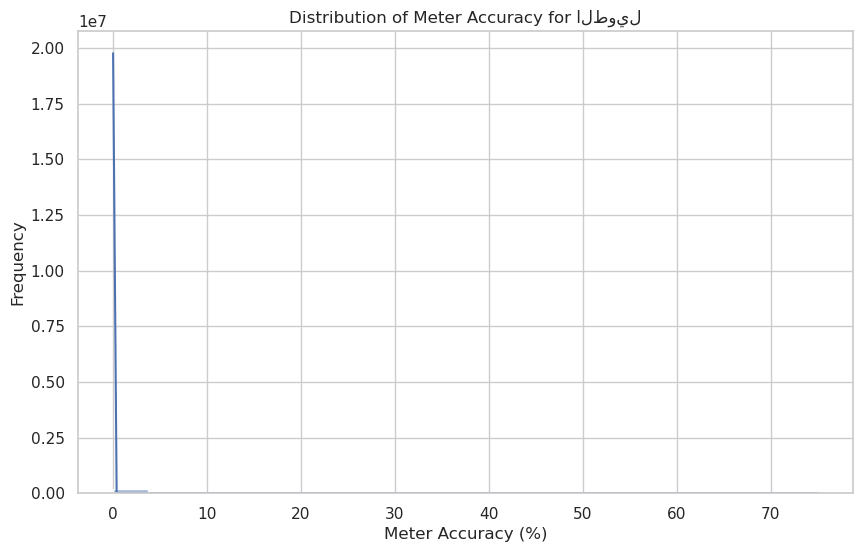

In [23]:

# Plot the distribution of meter accuracy
plt.figure(figsize=(10, 6))
sns.histplot(filtered_df['meter_accuracy'], bins=20, kde=True)
plt.title(f'Distribution of Meter Accuracy for {target_meter}')
plt.xlabel('Meter Accuracy (%)')
plt.ylabel('Frequency')
plt.show()

In [24]:
filtered_df.head()

,العصر,الشاعر,الديوان,القافية,البحر,الشطر الايسر,الشطر الايمن,البيت,final_albayt,passes_diacritization,text,meter_accuracy
0,قبل الإسلام,عمرو بنِ قُمَيئَة,الديوان الرئيسي,د,الطويل,وَأَن تَجمَعا شَملي وَتَنتَظِرا غَدا,خَليلَيَّ لا تَستَعجِلا أَن تَزَوَّدا,خَليلَيَّ لا تَستَعجِلا أَن تَزَوَّدا وَأَن...,خَليلَيَّ لا تَستَعجِلا أَن تَزَوَّدا وَأَن...,True,خَليلَيْيَ لا تَستَعجِلا ءَن تَزَوْوَدا وَء...,0.0
1,قبل الإسلام,عمرو بنِ قُمَيئَة,الديوان الرئيسي,د,الطويل,وَلا سُرعَتي يَوماً بِسابِقَةِ الرَدى,فَما لَبَثٌ يَوماً بِسابِقٍ مَغنَمٍ,فَما لَبَثٌ يَوماً بِسابِقٍ مَغنَمٍ وَلا سُ...,فَما لَبَثٌ يَوماً بِسابِقٍ مَغنَمٍ وَلا سُ...,True,فَما لَبَثُنْ يَومنْ بِسابِقِنْ مَغنَمِنْ و...,0.0
2,قبل الإسلام,عمرو بنِ قُمَيئَة,الديوان الرئيسي,د,الطويل,وَتَستَوجِبا مَنّاً عَلَيَّ وَتُحمَدا,وَإِن تُنظِراني اليَومَ أَقضِ لُبانَةً,وَإِن تُنظِراني اليَومَ أَقضِ لُبانَةً وَتَ...,وَإِن تُنظِراني اليَومَ أَقضِ لُبانَةً وَتَ...,True,وَءِن تُنظِراني اليَومَ ءَقضِ لُبانَتَنْ وَ...,0.0
3,قبل الإسلام,عمرو بنِ قُمَيئَة,الديوان الرئيسي,د,الطويل,تُؤامِرُني سِرّاً لِأَصرِمَ مَرثَدا,لَعَمرُكَ ما نَفسٌ بِجِدٍ رَشيدَةٍ,لَعَمرُكَ ما نَفسٌ بِجِدٍ رَشيدَةٍ تُؤامِرُ...,لَعَمرُكَ ما نَفسٌ بِجِدٍ رَشيدَةٍ تُؤامِرُ...,True,لَعَمرُكَ ما نَفسُنْ بِجِدِنْ رَشيدَتِنْ تُ...,0.0
4,قبل الإسلام,عمرو بنِ قُمَيئَة,الديوان الرئيسي,د,الطويل,وَأَفرَعَ في لَومي مِراراً وَأَصعَدا,وَإِن ظَهَرَت مِنهُ قَوارِصُ جَمَّةٌ,وَإِن ظَهَرَت مِنهُ قَوارِصُ جَمَّةٌ وَأَفر...,وَإِن ظَهَرَت مِنهُ قَوارِصُ جَمَّةٌ وَأَفر...,True,وَءِن ظَهَرَت مِنهُ قَوارِصُ جَمْمَتُنْ وَء...,0.0


In [ ]:
 Save the processed dataset
print("Saving the processed dataset...")
columns_to_save = [
    'final_albayt', 'البحر', 'poet', 'era', 'verse_length', 'meter_accuracy'
]
processed_df = filtered_df[columns_to_save].rename(columns={
    'final_albayt': 'text',
    'البحر': 'meter',
    'poet': 'poet',
    'era': 'era',
    'verse_length': 'verse_length',
    'meter_accuracy': 'meter_accuracy'
})
output_csv = os.path.join(processed_output_dir, 'processed_al_tawil.csv')
processed_df.to_csv(output_csv, index=False, encoding='utf-8-sig')
print(f"Processed dataset saved to {output_csv}")